In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore') 

import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('ufc_ml_dataset.csv', parse_dates=['DATE'])
df['year'] = df['DATE'].dt.year

# Potential X & y
Quite a few columns were kept in the ML dataset in case they would be useful. But let's start to hone in on the ones we really want to experiment with.

In [3]:
cols_of_interest = [
    'Red_Victory', # Dep Var
    # 'EVENT', # Text
    # 'BOUT', # Already extracted what we need
    # 'OUTCOME', # Already extracted what we need
    # 'WEIGHTCLASS',
    # 'METHOD',
    'ROUND',
    # 'TIME',
    'TIME FORMAT',
    # 'REFEREE', # Cardinality too high (225 distinct)
    # 'DETAILS', # Text
    # 'URL_fight',
    # 'FIGHTER_Red',
    # 'FIGHTER_Blue',
    # 'URL_event',
    # 'DATE', # TODO drop one of these dates
    # 'LOCATION',
    # 'EVENT_DATE',
    'gender',
    'weightclass',
    'STANCE_Red',
    # 'DOB_Red',
    'HEIGHT_in_Red',
    'WEIGHT_lbs_Red',
    'REACH_in_Red',
    'FIGHTER',
    'STANCE_Blue',
    'DOB_Blue',
    'HEIGHT_in_Blue',
    'WEIGHT_lbs_Blue',
    'REACH_in_Blue',
    'Age_yrs_Red',
    'Age_yrs_Blue',
    'WEIGHT_lbs_diff',
    'HEIGHT_in_diff',
    'REACH_in_diff',
    'Age_diff',
    'STANCE_diff',
    'Red_prior_fights',
    'Red_prior_victories',
    'Red_prior_losses',
    'Red_prior_f_win',
    'Blue_prior_fights',
    'Blue_prior_victories',
    'Blue_prior_losses',
    'Blue_prior_f_win',
    'year'
]

df = df[cols_of_interest]

In [4]:
text_cols = df.dtypes[df.dtypes == 'object'].index
num_cols = df.dtypes[df.dtypes == 'float64'].index

# Missingness

## Overall

In [5]:
px.line(
    df.isna().mean().sort_values(ascending=False).to_frame().rename(columns={0: 'Missing Rate'}).reset_index(),
    x='index',
    y='Missing Rate',
    markers=True
)

## By Year

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_missing_by_year = pd.merge(
    df.groupby('year', as_index=False).size().rename(columns={'size': 'Data Points'}),
    df.dropna().groupby('year', as_index=False).size().rename(columns={'size': 'Non-Null'}),
    on='year'
)

df_missing_by_year['Fraction Missing'] = 1 - (df_missing_by_year['Non-Null'] / df_missing_by_year['Data Points'])

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=df_missing_by_year['year'],
        y=df_missing_by_year['Data Points'],
        name='Data Points',
        mode='lines+markers'
    ),
    secondary_y=False,
)

# Add traces
fig.add_trace(
    go.Scatter(
        x=df_missing_by_year['year'],
        y=df_missing_by_year['Fraction Missing'],
        name='Fraction Missing',
        mode='lines+markers'
    ),
    secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="Data Points", secondary_y=False)
fig.update_yaxes(title_text="Fraction Missing", secondary_y=True)

fig.show()


## Drop remaining NA
This can be revisited. For now we want to move onto modeling so dropping rows with any missing values for the features of interest

In [7]:
print(len(df.index))
df = df.dropna()
print(len(df.index))


7882
7434


In [8]:
# missing_rate_by_year = 
# df.groupby('year').size() / 
df.groupby('year')['Age_diff']

# Post-2010 only
Prior to the year 2010 the Red victory rate was 100%. This is most likely an artifact of how the data was scraped. In the UFC stats website, older fights always list the winner as the top fighter.

<Axes: xlabel='year'>

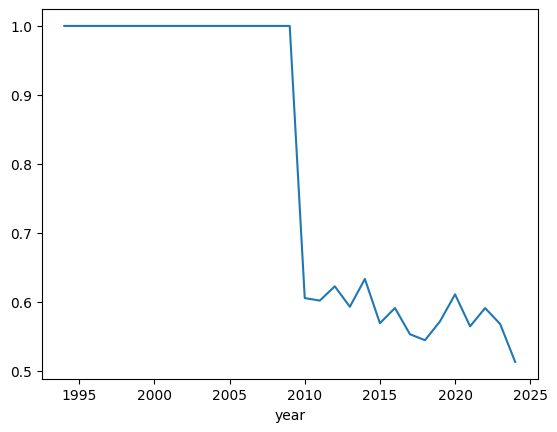

In [9]:
df.groupby('year')['Red_Victory'].mean().plot()

In [10]:
# Remove data prior to 2010
df = df[df['year'] >= 2010]
len(df.index)

6397

# EDA

## Correlations

<Axes: >

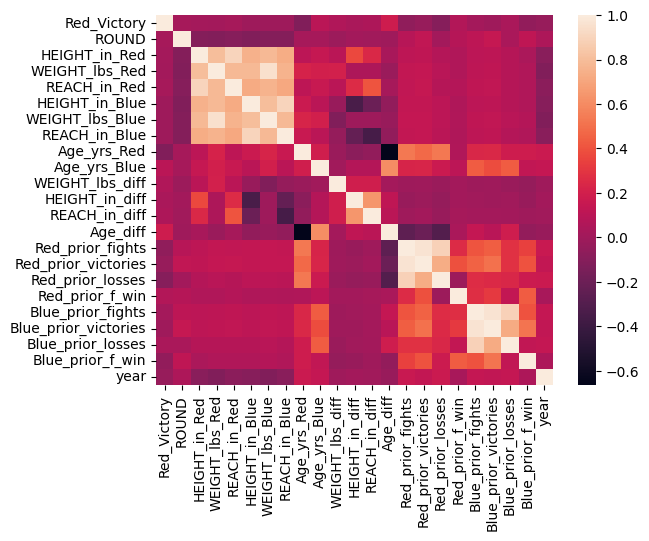

In [11]:
sns.heatmap(df.select_dtypes('number').corr())

## Univariate Analysis

In [12]:
df.Age_diff.value_counts()

Age_diff
-2.335451     8
-4.963859     7
 0.810426     7
 2.869346     7
 0.438068     6
             ..
 7.534772     1
 14.631475    1
-1.169094     1
-8.791480     1
-3.926186     1
Name: count, Length: 4164, dtype: int64

### Event Rates

In [13]:
# tmp = pd.cut(df['Age_diff'], bins=3)
# tmp.values
# for val in tmp.values:
#     print(val.left, val.right)
# tmp.categories
df_ = df.copy()
x_col = 'Age_diff'
y_col = 'Red_Victory'
bins=10

df_[f'{x_col}_binned'] = pd.cut(df_[x_col], bins=bins).apply(lambda x: f'{x.left} to {x.right}')

df_event_rate = df_.groupby(f'{x_col}_binned').agg(
    event_rate = (y_col, 'mean'),
    data_count = (y_col, 'size')
)

In [14]:
def event_rate(df_: pd.DataFrame, x_col: str, y_col: str, bins=10):

    df_ = df[[x_col, y_col]]

    x_col_binned = f'{x_col}_binned'
    df_[x_col_binned] = pd.cut(df_[x_col], bins=bins).apply(lambda x: f'{x.left} to {x.right}')

    df_event_rate = df_.groupby(x_col_binned, as_index=False).agg(
        event_rate = (y_col, 'mean'),
        data_count = (y_col, 'size')
    )

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(
            x=df_event_rate[x_col_binned],
            y=df_event_rate['event_rate'],
            name='Event Rate',
            mode='lines+markers'
        ),
        secondary_y=False
    )

    # Add traces
    fig.add_trace(
        go.Bar(
            x=df_event_rate[x_col_binned],
            y=df_event_rate['data_count'],
            name='Data Count',
            # mode='lines+markers'
        ),
        secondary_y=True,
    )

    # fig.data = fig.data[::-1]

    # Set x-axis title
    fig.update_xaxes(title_text=x_col_binned)

    # Set y-axes titles
    fig.update_yaxes(title_text="Event Rate", secondary_y=False)
    fig.update_yaxes(title_text="Data Count", secondary_y=True)
    fig.update_layout(title=x_col_binned)

    return df_event_rate, fig
    # return df_

In [16]:
numeric_features = df.dtypes[df.dtypes == 'float64'][1:].index

for col in numeric_features:
    # print(col)
    event_rate(df, col, 'Red_Victory', bins=5)[1].show()

### Information Value
Information value can be a good method for anticipating the univariate predictive power of a feature. While we can derive the multivariate importances using outputs of the ML models themselves, I find it valuable to understand my features before dumping them into a model.

A good primer on information value can be found [here](https://www.analyticsvidhya.com/blog/2021/06/understand-weight-of-evidence-and-information-value/), and I lifted the IV calculation function below from [here](https://medium.com/@srishtisawla/understanding-information-value-iv-in-machine-learning-5a2f147d6d3e) 

In [24]:
import pandas as pd
import numpy as np

def calculate_iv(df, feature, target):
    """
    Calculate the information value (IV) of a feature in a dataset.
    
    Parameters:
    df (pandas.DataFrame): the dataset
    feature (str): the name of the feature to calculate IV for
    target (str): the name of the target variable
    
    Returns:
    float: the information value (IV) of the feature
    """
    df = df[[feature, target]]
    df = df.dropna()
    n = df.shape[0]
    good = df[target].sum()
    bad = n - good
    unique_values = df[feature].unique()
    iv = 0
    for value in unique_values:
        n1 = df[df[feature] == value].shape[0]
        good1 = df[(df[feature] == value) & (df[target] == 1)].shape[0]
        bad1 = n1 - good1
        if good1 == 0 or bad1 == 0:
            continue
        woe = np.log((good1 / good) / (bad1 / bad))
        iv += (good1 / good - bad1 / bad) * woe
    return iv

From [this stack overflow article](https://stackoverflow.com/questions/60892714/how-to-get-the-weight-of-evidence-woe-and-information-value-iv-in-python-pan)

In [27]:
def calculate_iv2(df, feature, target):
    df_woe_iv = (pd.crosstab(df[feature],df[target],
                        normalize='columns')
                .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
                .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                            (dfx[1]-dfx[0]))))

    return df_woe_iv

In [29]:
calculate_iv2(df, 'HEIGHT_in_Red', 'Red_Victory')

Red_Victory,0.0,1.0,woe,iv
HEIGHT_in_Red,,,,
60.0,0.001119,0.000000,-inf,inf
61.0,0.007830,0.006729,-0.151463,inf
62.0,0.005220,0.004307,-0.192285,inf
63.0,0.016406,0.021265,0.259442,inf
64.0,0.030574,0.031225,0.021055,inf
65.0,0.041760,0.042261,0.011931,inf
66.0,0.077554,0.078331,0.009969,inf
67.0,0.083893,0.078869,-0.061744,inf
68.0,0.085384,0.088829,0.039555,inf


In [32]:
for col in numeric_features:
    print(col, ': ', calculate_iv(df, col, 'Red_Victory'))

HEIGHT_in_Red :  0.011837875171111527
WEIGHT_lbs_Red :  0.011275980274233573
REACH_in_Red :  0.04240255824547048
HEIGHT_in_Blue :  0.00664686870499057
WEIGHT_lbs_Blue :  0.015790925704743386
REACH_in_Blue :  0.047798845653266364
Age_yrs_Red :  0.165246058125079
Age_yrs_Blue :  0.1734463168938896
WEIGHT_lbs_diff :  0.038789233388118016
HEIGHT_in_diff :  0.01622517813162912
REACH_in_diff :  0.026206694263774293
Age_diff :  0.12658455745013633
Red_prior_fights :  0.03955536983231833
Red_prior_victories :  0.026599858312064573
Red_prior_losses :  0.05601976231493411
Red_prior_f_win :  0.12083149828636021
Blue_prior_fights :  0.018486891642170447
Blue_prior_victories :  0.02194651239807479
Blue_prior_losses :  0.009563743553001445
Blue_prior_f_win :  0.0645029558793499


# Basic modeling

In [16]:
# Create one-hot df

df_model = pd.get_dummies(df)
df_model

,Red_Victory,ROUND,HEIGHT_in_Red,WEIGHT_lbs_Red,REACH_in_Red,HEIGHT_in_Blue,WEIGHT_lbs_Blue,REACH_in_Blue,Age_yrs_Red,Age_yrs_Blue,...,STANCE_diff_Orthodox_Orthodox,STANCE_diff_Orthodox_Southpaw,STANCE_diff_Orthodox_Switch,STANCE_diff_Southpaw_Open Stance,STANCE_diff_Southpaw_Orthodox,STANCE_diff_Southpaw_Southpaw,STANCE_diff_Southpaw_Switch,STANCE_diff_Switch_Orthodox,STANCE_diff_Switch_Southpaw,STANCE_diff_Switch_Switch
0,1.0,5,69.0,125.0,68.0,67.0,125.0,70.000000,32.156938,24.709780,...,False,False,False,False,True,False,False,False,False,False
1,0.0,3,73.0,185.0,74.0,70.0,185.0,73.000000,36.811412,33.624466,...,True,False,False,False,False,False,False,False,False,False
2,1.0,3,75.0,170.0,80.0,72.0,170.0,77.000000,35.781952,30.853685,...,True,False,False,False,False,False,False,False,False,False
3,1.0,2,70.0,155.0,72.0,67.0,155.0,70.000000,30.642865,30.188369,...,False,False,False,False,False,False,False,True,False,False
4,1.0,3,73.0,170.0,74.0,71.0,170.0,72.000000,37.783375,34.158362,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6612,1.0,1,72.0,170.0,72.0,69.0,155.0,71.000000,27.713284,29.325923,...,False,True,False,False,False,False,False,False,False,False
6613,1.0,1,73.0,145.0,73.0,70.0,155.0,71.587467,25.687219,21.761034,...,True,False,False,False,False,False,False,False,False,False
6614,1.0,1,72.0,185.0,71.0,73.0,185.0,76.000000,31.896835,32.285620,...,True,False,False,False,False,False,False,False,False,False
6615,1.0,2,69.0,170.0,71.0,72.0,170.0,74.000000,24.767276,34.292520,...,True,False,False,False,False,False,False,False,False,False


In [17]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['Red_Victory'])
y = df_model['Red_Victory']


## LR

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.600625

In [19]:
df.Red_Victory.mean()

np.float64(0.58074097233078)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.600625

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.53      0.53       685
         1.0       0.65      0.65      0.65       915

    accuracy                           0.60      1600
   macro avg       0.59      0.59      0.59      1600
weighted avg       0.60      0.60      0.60      1600

[[366 319]
 [320 595]]


## Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

clf = DecisionTreeClassifier()

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3)

# Train the model
clf = clf.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.53      0.53       685
         1.0       0.65      0.65      0.65       915

    accuracy                           0.60      1600
   macro avg       0.59      0.59      0.59      1600
weighted avg       0.60      0.60      0.60      1600

[[366 319]
 [320 595]]


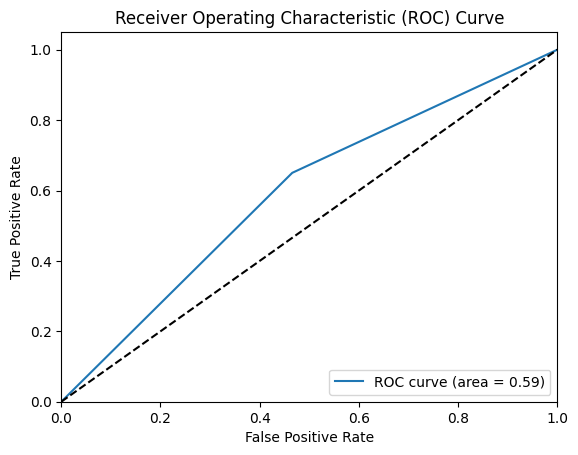

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

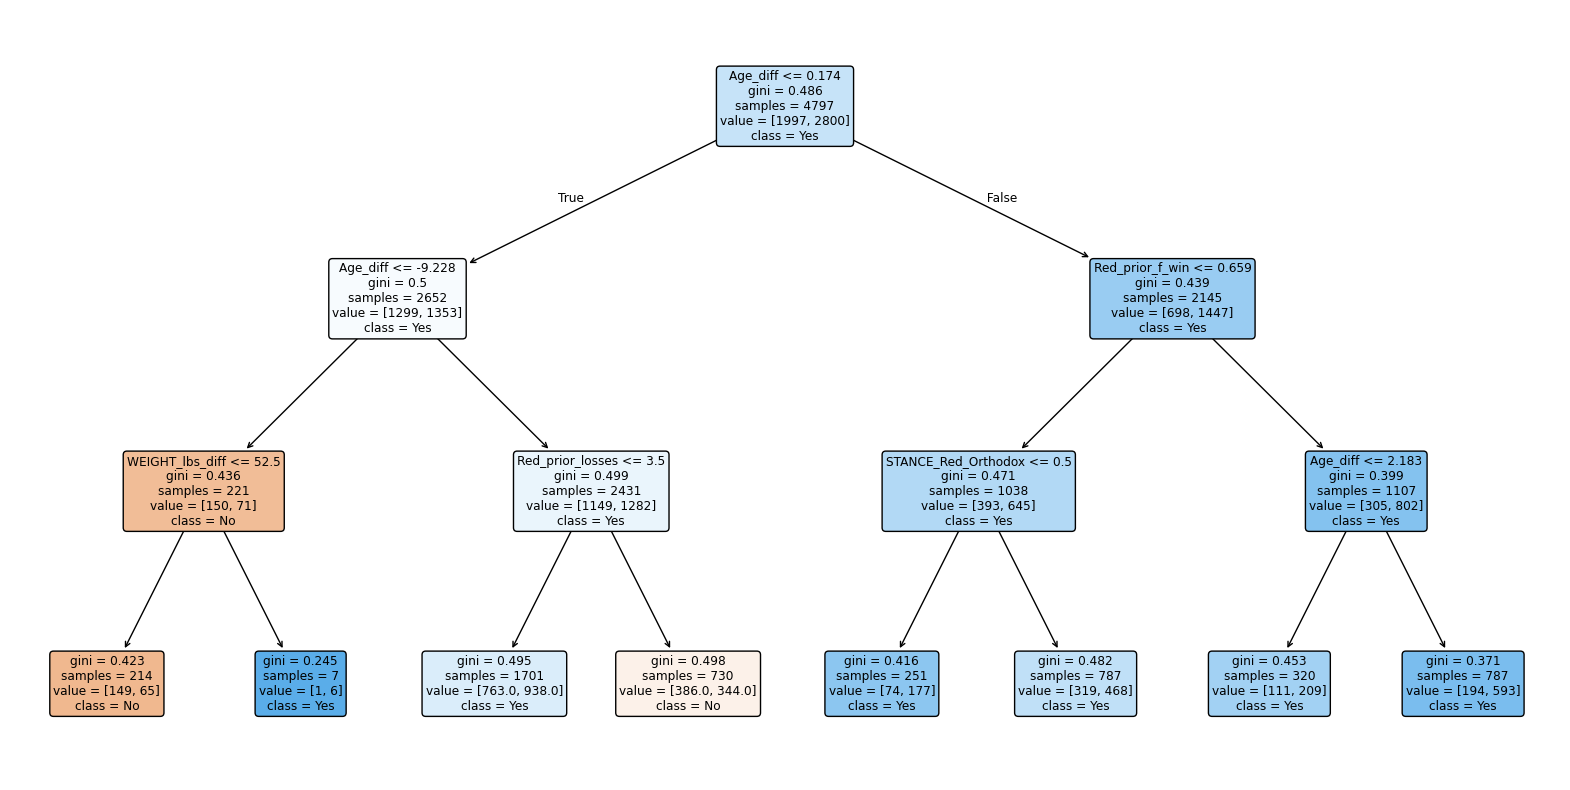

In [24]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, rounded=True, class_names=['No', 'Yes'], feature_names=X.columns)
plt.show()

In [25]:
(0.6-0.58) / 0.58

0.03448275862068969

## RF

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#  Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

rf.feature_importances_

Accuracy: 0.580625


array([0.01448384, 0.02460891, 0.01836739, ..., 0.0019427 , 0.00080466,
       0.00037345])

In [27]:
X.shape[1]

3589

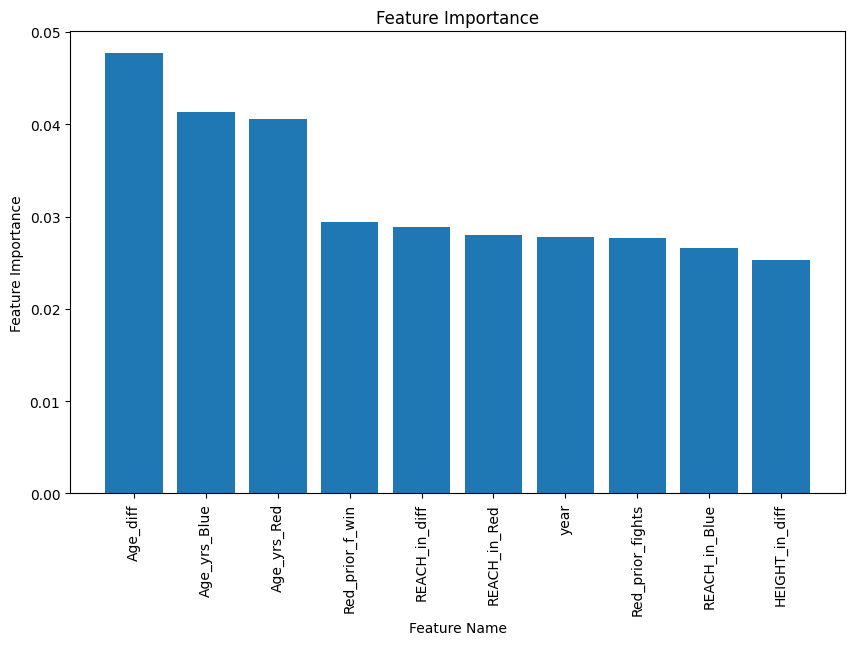

In [28]:
import numpy as np

# Get feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
# plt.bar(range(X.shape[1]), importances[indices])
plt.bar(range(10), importances[indices][:10])
# plt.xticks(range(X.shape[1]), names, rotation=90)
plt.xticks(range(10), names[:10], rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")
plt.show()